<a href="https://colab.research.google.com/github/JulieOnIsland/DeepLearningforAI_class_2022/blob/main/coding_with_MrChollet_ch7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch 7: Working with Keras: A deep dive

This chapter covers the following:
* Functional API
* Using built-in Keras training and evaluation loops
* Using Keras callbacks to customize training
* Using TensorBoard to monitor training and evaluation metrics

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers

## Functional API

In [ ]:
inputs = keras.Input(shape=(3,), name='my_input')
features = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
features.shape

TensorShape([None, 64])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


## Multi-input, Multi-output model

In [ ]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")


In [ ]:
features = layers.Concatenate()([title, text_body, tags])

In [ ]:
features.shape

TensorShape([None, 20100])

In [ ]:
featuers = layers.Dense(64, activation='relu')(features)

In [ ]:
priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(
    num_departments, activation='softmax', name='department'
)(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

In [ ]:
import numpy as np
num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [ ]:
print(priority_data)
print(priority_data.shape)

[[0.38605503]
 [0.07248777]
 [0.82582524]
 ...
 [0.73982489]
 [0.97650184]
 [0.2867654 ]]
(1280, 1)


In [ ]:
print(department_data)
print(department_data.shape)

[[1 0 0 0]
 [1 0 0 0]
 [1 1 1 0]
 ...
 [1 1 1 0]
 [1 1 1 0]
 [0 0 1 0]]
(1280, 4)


In [ ]:
model.compile(optimizer='rmsprop',
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[['mae'], ['acc']])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=2)

Epoch 1/2
40/40 [==============================] - 1s 5ms/step - loss: 15.6892 - priority_loss: 0.3188 - department_loss: 15.3704 - priority_mae: 0.4846 - department_acc: 0.2719
Epoch 2/2
40/40 [==============================] - 0s 5ms/step - loss: 12.3627 - priority_loss: 0.3188 - department_loss: 12.0439 - priority_mae: 0.4846 - department_acc: 0.2680


In [ ]:
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])

40/40 [==============================] - 0s 5ms/step - loss: 18.8285 - priority_loss: 0.3188 - department_loss: 18.5097 - priority_mae: 0.4846 - department_acc: 0.1336


[18.828536987304688,
 0.31880250573158264,
 18.509733200073242,
 0.4846019148826599,
 0.13359375298023224]

In [ ]:
priority_preds, department_preds = model.predict([title_data, 
                                                  text_body_data, 
                                                  tags_data])

In [ ]:
print(priority_preds)
print('----------------------------')
print(department_preds)

[[1.6149061e-11]
 [7.0753642e-12]
 [7.9185321e-12]
 ...
 [2.3224018e-11]
 [1.5549340e-11]
 [1.3666791e-11]]
----------------------------
[[4.5369379e-04 1.5891300e-06 9.9954385e-01 8.8055185e-07]
 [7.2697067e-06 1.9513145e-07 9.9999249e-01 2.1457899e-08]
 [3.7549227e-05 2.2585262e-07 9.9996150e-01 7.0930940e-07]
 ...
 [7.3805434e-04 4.1175963e-07 9.9926156e-01 5.2963205e-08]
 [2.6941334e-04 1.4831872e-07 9.9973041e-01 2.4688402e-08]
 [1.0468077e-03 2.7422291e-07 9.9895239e-01 4.3059771e-07]]


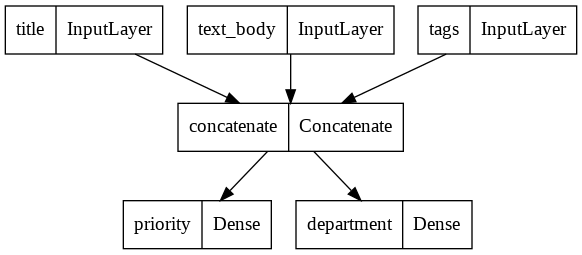

In [ ]:
keras.utils.plot_model(model, 'ticket_classifier.png')

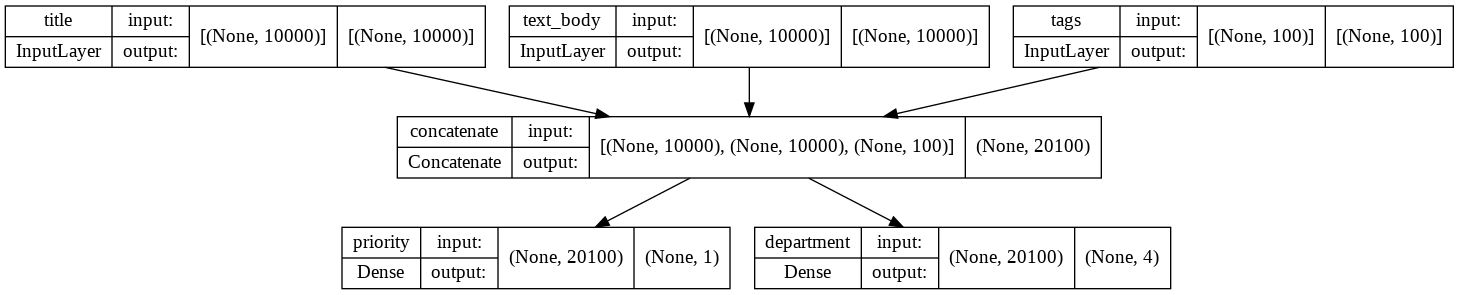

In [ ]:
keras.utils.plot_model(model, 'ticket_classifier_with_shape_info.png', show_shapes=True)

## Evaluation loops


```
The standard workflow: 
compile() ➡ fit() ➡ evaluate() ➡ predict()
```



In [ ]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28*28)).astype('float32') / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
model = get_mnist_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.fit(train_images, 
          train_labels,
          epochs=3,
          verbose=2,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 - 5s - loss: 0.2893 - acc: 0.9117 - val_loss: 0.1407 - val_acc: 0.9558 - 5s/epoch - 3ms/step
Epoch 2/3
1563/1563 - 4s - loss: 0.1475 - acc: 0.9561 - val_loss: 0.1035 - val_acc: 0.9681 - 4s/epoch - 2ms/step
Epoch 3/3
1563/1563 - 4s - loss: 0.1146 - acc: 0.9642 - val_loss: 0.0929 - val_acc: 0.9725 - 4s/epoch - 2ms/step
313/313 [==============================] - 1s 3ms/step - loss: 0.0862 - acc: 0.9732


In [ ]:
print(test_metrics)
print('--------------')
print(predictions)

[0.08618069440126419, 0.9732000231742859]
--------------
[[1.99312126e-07 1.81769181e-07 2.77504805e-05 ... 9.99931931e-01
  1.19343184e-07 1.12797634e-05]
 [6.07104855e-09 7.80272312e-05 9.99893665e-01 ... 1.45705933e-10
  1.45851303e-07 2.03698300e-12]
 [2.14893845e-07 9.99805510e-01 1.38379846e-05 ... 1.00639074e-04
  1.44756787e-05 1.53709735e-07]
 ...
 [4.23690971e-10 1.16068977e-08 1.30034405e-09 ... 1.12642356e-05
  3.05174376e-06 2.56704836e-04]
 [3.29262775e-07 6.38115125e-08 1.78785778e-10 ... 6.39547360e-10
  3.04011955e-05 2.07242579e-09]
 [2.74315592e-08 5.42740713e-11 6.08862791e-08 ... 1.75224662e-13
  7.78009213e-09 2.32238829e-11]]


In [ ]:
print(predictions.shape)

(10000, 10)


In [ ]:
predictions[0]

array([1.9931213e-07, 1.8176918e-07, 2.7750481e-05, 2.8053477e-05,
       4.1617079e-10, 4.5780604e-07, 1.4038265e-11, 9.9993193e-01,
       1.1934318e-07, 1.1279763e-05], dtype=float32)

In [ ]:
preds = []
for i in range(predictions.shape[0]):
    preds.append(np.argmax(predictions[i]))

In [ ]:
preds[:5]

[7, 2, 1, 0, 4]

## Using callbacks
* EarlyStopping
* ModelCheckpoint

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='checkpoint_path.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

In [ ]:
model = get_mnist_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.fit(train_images,
          train_labels,
          epochs=10,
          verbose=2,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 - 4s - loss: 0.2893 - acc: 0.9133 - val_loss: 0.1439 - val_acc: 0.9583 - 4s/epoch - 3ms/step
Epoch 2/10
1563/1563 - 4s - loss: 0.1478 - acc: 0.9549 - val_loss: 0.1060 - val_acc: 0.9690 - 4s/epoch - 2ms/step
Epoch 3/10
1563/1563 - 4s - loss: 0.1139 - acc: 0.9635 - val_loss: 0.0821 - val_acc: 0.9759 - 4s/epoch - 2ms/step
Epoch 4/10
1563/1563 - 3s - loss: 0.0986 - acc: 0.9685 - val_loss: 0.0818 - val_acc: 0.9743 - 3s/epoch - 2ms/step
Epoch 5/10
1563/1563 - 4s - loss: 0.0833 - acc: 0.9736 - val_loss: 0.0754 - val_acc: 0.9777 - 4s/epoch - 2ms/step
Epoch 6/10
1563/1563 - 3s - loss: 0.0770 - acc: 0.9761 - val_loss: 0.0733 - val_acc: 0.9781 - 3s/epoch - 2ms/step
Epoch 7/10
1563/1563 - 3s - loss: 0.0675 - acc: 0.9781 - val_loss: 0.0728 - val_acc: 0.9788 - 3s/epoch - 2ms/step
Epoch 8/10
1563/1563 - 4s - loss: 0.0616 - acc: 0.9797 - val_loss: 0.0683 - val_acc: 0.9802 - 4s/epoch - 2ms/step
Epoch 9/10
1563/1563 - 3s - loss: 0.0573 - acc: 0.9810 - val_loss: 0.0710 - val_acc: 0.9

In [ ]:
saved_model = keras.models.load_model('checkpoint_path.keras')

In [ ]:
saved_model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0651 - acc: 0.9797


[0.06512525677680969, 0.9797000288963318]

Compared to the previous model's test metrics ([0.086, 0.973]), saved_model's loss and accuracy are better.